## Visualising and animating different Gradient Descent Optimisation techniques

In [2]:
# A bit of setup

%matplotlib inline
%load_ext autoreload
%autoreload 2

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from autograd import elementwise_grad
from IPython.display import HTML
from matplotlib import animation
from itertools import zip_longest
import numpy as np

plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelpad'] = 8

#### Let's evaluate the performance on Beale's function. This is represented as: 
$$f(x,y)=(1.5−x+xy)^{2}+(2.25−x+xy^2)^2+(2.625−x+xy^3)^2$$

In [3]:
f = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [4]:
xmin, xmax, xstep = -4.5, 4.5, 0.2
ymin, ymax, ystep = -4.5, 4.5, 0.2

xx, yy = np.meshgrid(np.arange(xmin, xmax, xstep),
                    np.arange(ymin, ymax, ystep))

z = f(xx, yy)

# we know the global minima is at (3, 0.5)
gmin = np.array([3, 0.5])
gmin = gmin.reshape((-1, 1))
f(*gmin)

array([ 0.])

(-4.5, 4.5)

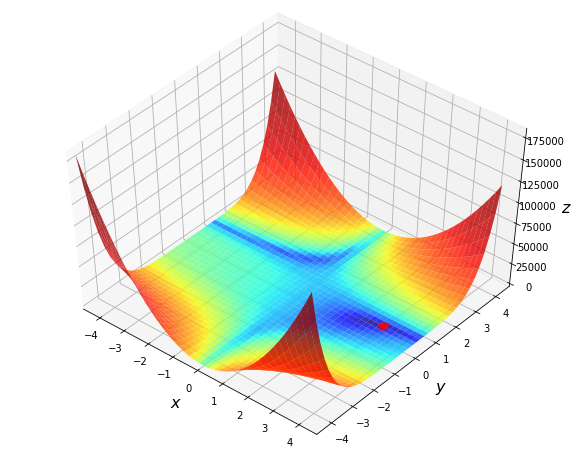

In [5]:
# Create a 3D Surface plot
ax = plt.axes(projection='3d', elev=50, azim=-50)
ax.plot_surface(xx, yy, z, norm=LogNorm(), rstride=1, cstride=1,
               edgecolor='none', alpha=0.8, cmap=plt.cm.jet)
ax.plot(*gmin, f(*gmin), 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

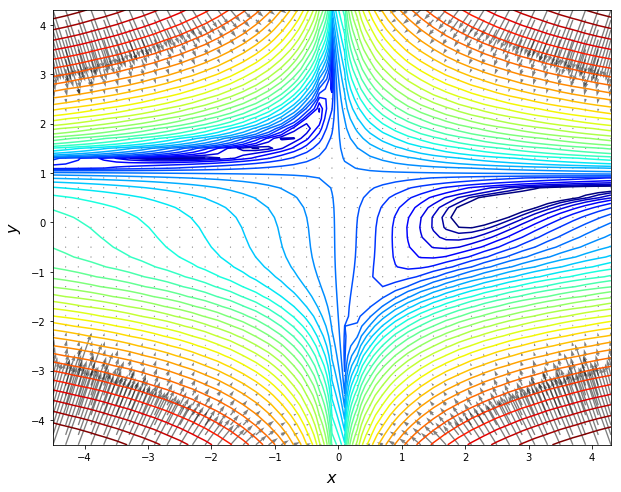

In [6]:
# Create a Contour plot and gradient vector field
dz_dxx = elementwise_grad(f, argnum=0)(xx, yy)
dz_dyy = elementwise_grad(f, argnum=1)(xx, yy)

ax = plt.subplot()
ax.contour(xx, yy, z, norm=LogNorm(), levels=np.logspace(0, 5, 35),
           cmap=plt.cm.jet)
ax.quiver(xx, yy, xx - dz_dxx, yy - dz_dyy, alpha=0.5)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [7]:
import tensorflow as tf

def minimise_beales_with(opt, path=[], init_values=[1.5, 2.5]):
    x = tf.Variable(init_values[0])
    y = tf.Variable(init_values[1])

    obj = (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

    # Important to clip the max and min values of x and y to
    # -4.5 and 4.5 so that they don't explode to infinite.
    grads_and_vars = opt.compute_gradients(obj, [x, y])
    clipped_grads_and_vars = [(tf.clip_by_value(g, -4.5, 4.5), v) for g, v in grads_and_vars]

    train = opt.apply_gradients(clipped_grads_and_vars)

    with tf.Session() as session:
        session.run(tf.global_variables_initializer())

        for i in range(5000):
            _, x_, y_ = session.run([train, x, y])
            if i %20 == 0:
                path.append([x_, y_])
        print(session.run(obj))

path = []
optimiser = tf.train.AdadeltaOptimizer(0.2, rho=0.999, epsilon=1e-4)
minimise_beales_with(optimiser, path) 
path = np.array(path).T
path.shape

2.39062e-11


(2, 250)

(-4.5, 4.5)

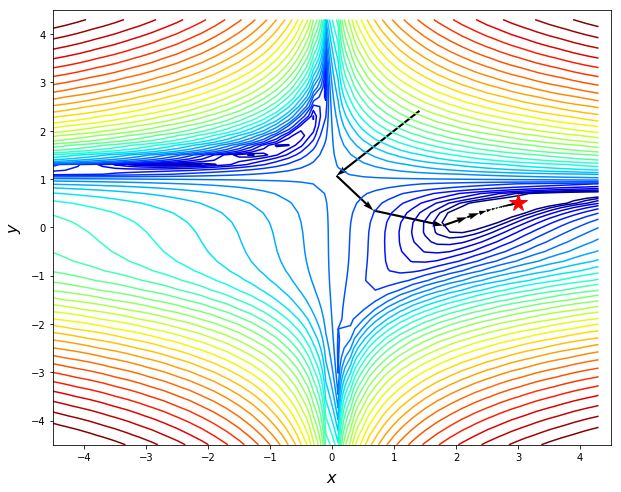

In [8]:
# Static quiver plot of the path on the 2D contour plot
ax = plt.subplot()
ax.contour(xx, yy, z, levels=np.logspace(0, 5, 35), norm=LogNorm(),
           cmap=plt.cm.jet)
ax.quiver(path[0, :-1], path[1, :-1],
          path[0,1:] - path[0, :-1],
          path[1, 1:] - path[1, :-1], 
          scale_units='xy', angles='xy', scale=1, color='k')
ax.plot(*gmin, 'r*', markersize=18)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

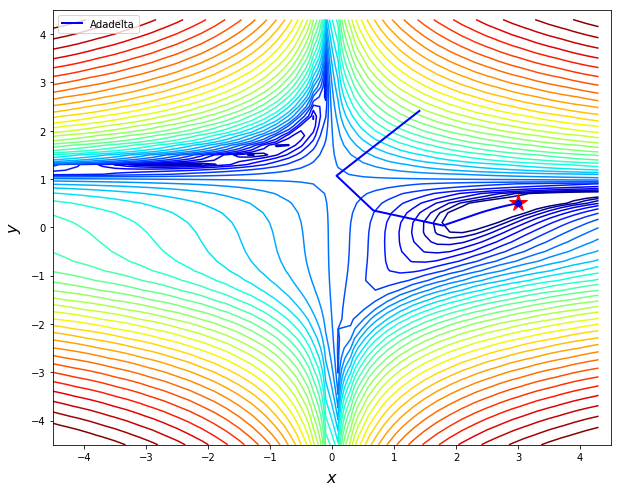

In [9]:
# Animation on the 2D Contour plot
fig, ax = plt.subplots()

ax.contour(xx, yy, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*gmin, 'r*', markersize=18)

line, = ax.plot([], [], 'b', label='Adadelta', lw=2)
point, = ax.plot([], [], 'bo')

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

ax.legend(loc='upper left')

def init():
    line.set_data([], [])
    point.set_data([], [])
    return line, point

def animate(i):
    line.set_data(*path[::,:i])
    point.set_data(*path[::,i-1:i])
    return line, point

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=path.shape[1], interval=60, 
                               repeat_delay=5, blit=True)
HTML(anim.to_html5_video())

In [10]:
# Abstraction of the animation functionality to support concurrent trajectory
# visualisations
class TrajectoryAnimation(animation.FuncAnimation):
    def __init__(self, *paths, labels=[], fig=None, ax=None,
                frames=None, interval=80, repeat_delay=5, blit=True, **kwargs):
        if fig is None:
            if ax is None:
                fig, ax = plt.subplots()
            else:
                fig = ax.get_figure()
        else:
            if ax is None:
                ax = fig.gca()
        
        self.fig = fig
        self.ax = ax
        self.paths = paths
        
        if frames is None:
            frames = max([path.shape[1] for path in paths])
            
        self.lines = [ax.plot([], [], label=label, lw=2)[0] 
                     for _, label in zip_longest(paths, labels)]
        
        self.points = [ax.plot([], [], 'o', color=line.get_color())[0]
                      for line in self.lines]
        
        super().__init__(fig, self.animate, init_func=self.init_anim,
                       frames=frames, interval=interval, 
                       repeat_delay=repeat_delay, blit=blit, **kwargs)
    
    def init_anim(self):
        for line, point in zip(self.lines, self.points):
            line.set_data([], [])
            point.set_data([], [])
        return self.lines + self.points
    
    def animate(self, i):
        for line, point, path in zip(self.lines, self.points, self.paths):
            line.set_data(*path[:, :i])
            point.set_data(*path[:, i-1:i])
        return self.lines + self.points

3.00121e-09
3.97823e-07
3.64082e-11
0.0244609
7.53942e-09
1.99994e-10


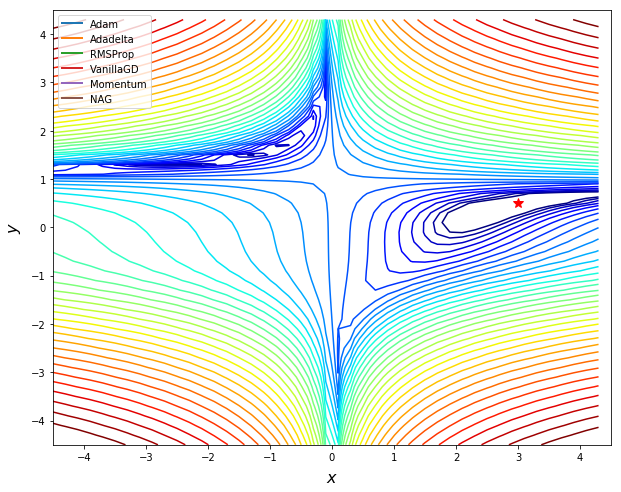

In [11]:
# Simultaneous trajectory plotting
optimisers = [
    tf.train.AdamOptimizer(0.005),
    tf.train.AdadeltaOptimizer(0.05, rho=0.999, epsilon=1e-4),
    tf.train.RMSPropOptimizer(0.005, decay=0.999, epsilon=1e-4),
    tf.train.GradientDescentOptimizer(0.0005, name='VanillaGD'),
    tf.train.MomentumOptimizer(learning_rate=0.0005, momentum=0.9),
    tf.train.MomentumOptimizer(learning_rate=0.0005, momentum=0.95, use_nesterov=True, name="NAG")
]

paths_ = {opt.get_name(): [] for opt in optimisers}

# Perform optimisations
for optimiser in optimisers:
    minimise_beales_with(optimiser, paths_[optimiser.get_name()])

paths = [np.array(paths_[opt.get_name()]).T for opt in optimisers]

fig, ax = plt.subplots()

ax.contour(xx, yy, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*gmin, 'r*', markersize=10)

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

labels = [opt.get_name() for opt in optimisers]
anim = TrajectoryAnimation(*paths, labels=labels, ax=ax)

ax.legend(loc='upper left')

In [12]:
HTML(anim.to_html5_video())

In [14]:
# Save animation
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='sidroopdaska'), bitrate=1800)
anim.save('optimisationVis.mp4', writer=writer)